In [0]:
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split 
import copy
from xgboost import XGBClassifier

#Data Processing

In [83]:
df = pd.read_csv('training_data_small.csv')
nan_sum = df.isna().sum()
print(nan_sum)

nan_to_remove_list = ['YEARS_SINCE_AT_FAULT_CLAIM', 
                      'YEARS_SINCE_NOT_AT_FAULT_CLAIM', 
                      'YEARS_SINCE_MINOR_CONVICTION', 
                      'YEARS_SINCE_MAJOR_CONVICTION', 
                      'YEARS_SINCE_SERIOUS_CONVICTION',
                      'DRIVING_EXPERIENCE',
                      'YEARS_WITH_PRIOR_COMPANY',
                     ]
loss_list = ['INCURRED_LOSS_COLLISION', 'INCURRED_LOSS_COMPREHENSIVE', 'INCURRED_LOSS_DCPD']

deductible = ['DEDUCTIBLE_COLLISION',
              'DEDUCTIBLE_COMPREHENSIVE',
              'DEDUCTIBLE_DCPD']
'''convictions = ['MINOR_CONVICTIONS',     
              'MAJOR_CONVICTIONS',     
              'SERIOUS_CONVICTIONS'] '''

df.fillna(method='ffill', inplace=True)
gender = df.pop('GENDER')
status = df.pop('DRIVER_MARTIAL_STATUS')
ind = df.pop('DRIVER_TRAINING_IND')
df['MALE'] = (gender == 'M')*1.0
df['FEMALE'] = (gender == 'F')*1.0
df['STATUS_M'] = (status == 'M')*1.0
df['STATUS_S'] = (status == 'S')*1.0
df['TRAINING_IND_N'] = (ind == 'N')*1.0
df['TRAINING_IND_Y'] = (ind == 'Y')*1.0

df = df.fillna(df.mean())
nan_sum = df.isna().sum()
print(nan_sum)

LATITUDE                           1608
LONGITUDE                          4298
AGE                                 786
YEARS_WITH_COMPANY                 1206
ANNUAL_KILOMETERS                  4545
DAILY_KILOMETERS                   1357
YEARS_LICENSED                     1494
VEHICLE_YEAR                       3792
NUMBER_OF_DRIVERS                  3765
NUMBER_OF_VEHICLES                 8971
PRIOR_COMPANY                      1231
DEDUCTIBLE_COLLISION               1659
DEDUCTIBLE_COMPREHENSIVE            985
DEDUCTIBLE_DCPD                    9034
PAYMENT_METHOD                    14417
AT_FAULT_CLAIMS                    1369
NOT_AT_FAULT_CLAIMS               13256
MINOR_CONVICTIONS                  4742
MAJOR_CONVICTIONS                   913
SERIOUS_CONVICTIONS                7555
DRIVING_EXPERIENCE                83012
YEARS_WITH_PRIOR_COMPANY          83524
INCURRED_LOSS_COLLISION               0
INCURRED_LOSS_COMPREHENSIVE           0
INCURRED_LOSS_DCPD                    0


#XGBoost

In [84]:
for i in range(len(loss_list)):   
  df['DEDUCTIBLE'] = df[deductible[i]]
  print(len(df))
  df['LOSS_TOTAL'] = df[loss_list[i]]  
  df['LOSSINCURRED'] = np.sign(df.LOSS_TOTAL)
  #df.describe()
  train = copy.deepcopy(df)

  # Remove feature we don't care about
  for loss in loss_list:
    train.pop(loss)
  for nan in nan_to_remove_list:
    train.pop(nan)  
  for d in deductible:
    train.pop(d)
  train.pop('LOSS_TOTAL')
  
  #Choose important feature
  important_feature=[]
  for col in [i for i in train.columns if i not in ['LOSSINCURRED']]:    
      p_val=sp.stats.pearsonr(train[col],train["LOSSINCURRED"])
      if (np.abs(p_val[0]) > 0.001):
        important_feature.append(col)

  # Data for important feature       
  X = train[important_feature]
  # target value which is 0 or 1
  y = train['LOSSINCURRED']
  
  # Cross validation to valid data accuracy
  x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=3)

  # change model to anything you want
  clf = XGBClassifier(    
                          n_estimators=300,
                          max_depth=4,
                          objective="binary:logistic",
                          learning_rate=0.07, 
                          subsample=.8,
                          min_child_weight=6,
                          colsample_bytree=.8,
                          scale_pos_weight=1.6,
                          gamma=10,
                          reg_alpha=8,
                          reg_lambda=1.3,
                       )

  model = clf.fit( x_train, y_train )
  cv = 5
  print('\n--- Train Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
  print('\n--- Validation Set -----------------------------')    
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
  print('-----------------------------------------------') 
#cor = train.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

100000

--- Train Set -----------------------------
Accuracy: 0.94793 +/- 0.0000
AUC: 0.49932 +/- 0.0051

--- Validation Set -----------------------------
Accuracy: 0.94487 +/- 0.0001
AUC: 0.50406 +/- 0.0138
-----------------------------------------------
100000

--- Train Set -----------------------------
Accuracy: 0.94719 +/- 0.0000
AUC: 0.50532 +/- 0.0118

--- Validation Set -----------------------------
Accuracy: 0.94667 +/- 0.0000
AUC: 0.50787 +/- 0.0068
-----------------------------------------------
100000

--- Train Set -----------------------------
Accuracy: 0.94893 +/- 0.0000
AUC: 0.49559 +/- 0.0083

--- Validation Set -----------------------------
Accuracy: 0.94723 +/- 0.0001
AUC: 0.50772 +/- 0.0101
-----------------------------------------------


#Prediction Loss

26536


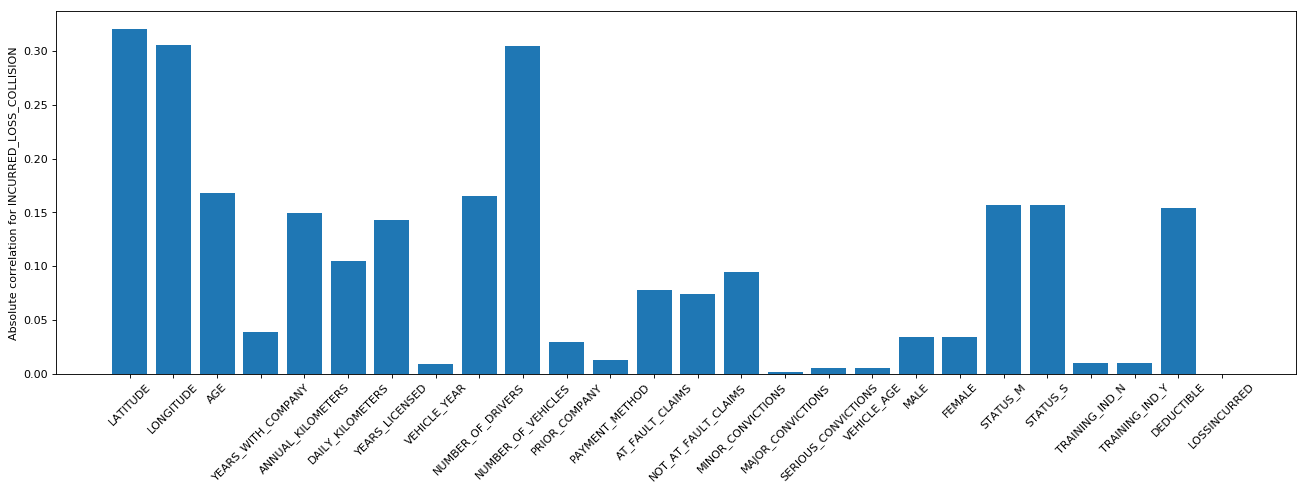

['LATITUDE', 'LONGITUDE', 'AGE', 'YEARS_WITH_COMPANY', 'ANNUAL_KILOMETERS', 'DAILY_KILOMETERS', 'YEARS_LICENSED', 'NUMBER_OF_DRIVERS', 'NUMBER_OF_VEHICLES', 'PRIOR_COMPANY', 'PAYMENT_METHOD', 'AT_FAULT_CLAIMS', 'NOT_AT_FAULT_CLAIMS', 'MINOR_CONVICTIONS', 'MALE', 'FEMALE', 'STATUS_M', 'STATUS_S', 'DEDUCTIBLE']
INCURRED_LOSS_COLLISION
Mean Absolute Error: 0.1758247155022049
Mean Squared Error: 0.05806102269176818
Root Mean Squared Error: 0.24095854973785052
26298


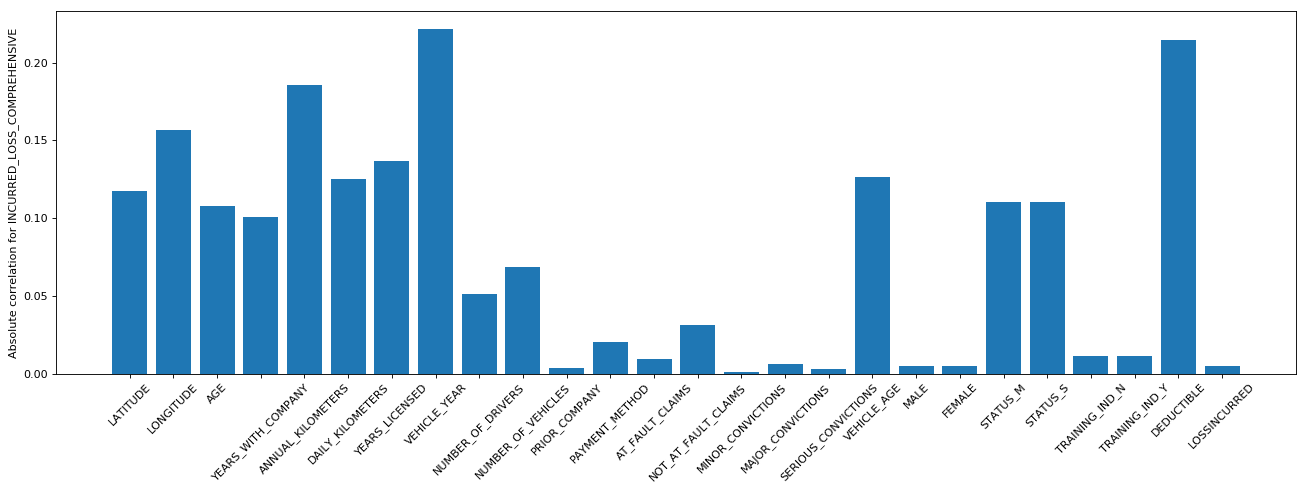

['LATITUDE', 'LONGITUDE', 'AGE', 'YEARS_WITH_COMPANY', 'ANNUAL_KILOMETERS', 'DAILY_KILOMETERS', 'YEARS_LICENSED', 'VEHICLE_YEAR', 'NUMBER_OF_DRIVERS', 'NUMBER_OF_VEHICLES', 'PAYMENT_METHOD', 'NOT_AT_FAULT_CLAIMS', 'VEHICLE_AGE', 'STATUS_M', 'STATUS_S', 'TRAINING_IND_N', 'TRAINING_IND_Y', 'DEDUCTIBLE']
INCURRED_LOSS_COMPREHENSIVE
Mean Absolute Error: 0.16775421053058198
Mean Squared Error: 0.049684011007337305
Root Mean Squared Error: 0.22289910499447346
25718


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


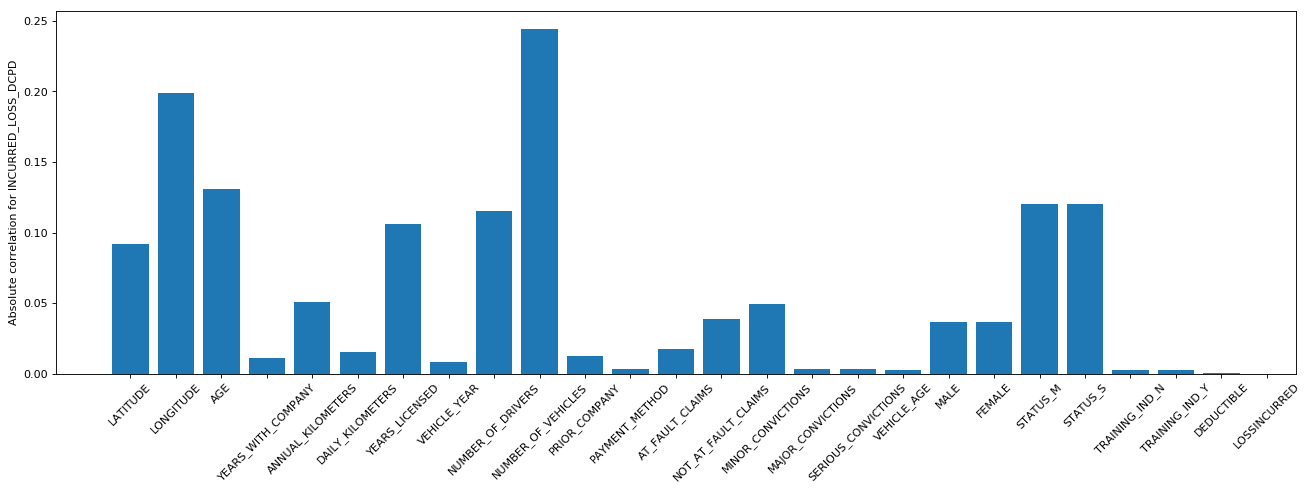

['LATITUDE', 'LONGITUDE', 'AGE', 'YEARS_WITH_COMPANY', 'ANNUAL_KILOMETERS', 'DAILY_KILOMETERS', 'YEARS_LICENSED', 'NUMBER_OF_DRIVERS', 'NUMBER_OF_VEHICLES', 'PRIOR_COMPANY', 'AT_FAULT_CLAIMS', 'NOT_AT_FAULT_CLAIMS', 'MINOR_CONVICTIONS', 'MALE', 'FEMALE', 'STATUS_M', 'STATUS_S']
INCURRED_LOSS_DCPD
Mean Absolute Error: 0.10289508384858287
Mean Squared Error: 0.028038839007790927
Root Mean Squared Error: 0.1674480188231289


In [68]:
for i in range(len(loss_list)):  
  df['LOSS'] = df[loss_list[i]]  
  df['DEDUCTIBLE'] = df[deductible[i]]
  ilc = df.loc[df['LOSS'] > 0]# copy.deepcopy(df)#df.loc[df['LOSS'] > 0]
  
  # Remove we don't care
  for loss in loss_list:
    ilc.pop(loss)
  for nan in nan_to_remove_list:
    ilc.pop(nan)  
  for d in deductible:
    ilc.pop(d)
    
    
  #for d in convictions:
  #  ilc.pop(d)
  print(len(ilc))  
  #corr_vals=[]
  #collabel=[]
  #figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
  important_feature=[]
  for col in [i for i in ilc.columns if i not in ['LOSS']]:    
      p_val=sp.stats.pearsonr(ilc[col],ilc["LOSS"])
      #corr_vals.append(np.abs(p_val[0]))
      ##print(col,": ",np.abs(p_val[0]))
      #collabel.append(col)
      if (np.abs(p_val[0]) > 0.01):
        important_feature.append(col)
        
  #plt.bar(range(1,len(corr_vals)+1),corr_vals)
  #plt.xticks(range(1,len(corr_vals)+1),collabel,rotation=45)
  #plt.ylabel("Absolute correlation for " + loss_list[i])
  #plt.show()
  #print(important_feature)
  
  # Feature data
  X = ilc[important_feature
  # Target loss        
  y = np.log(ilc['LOSS'])
  
  # Crossvalidation 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
          
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  print(loss_list[i])
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#Correlation

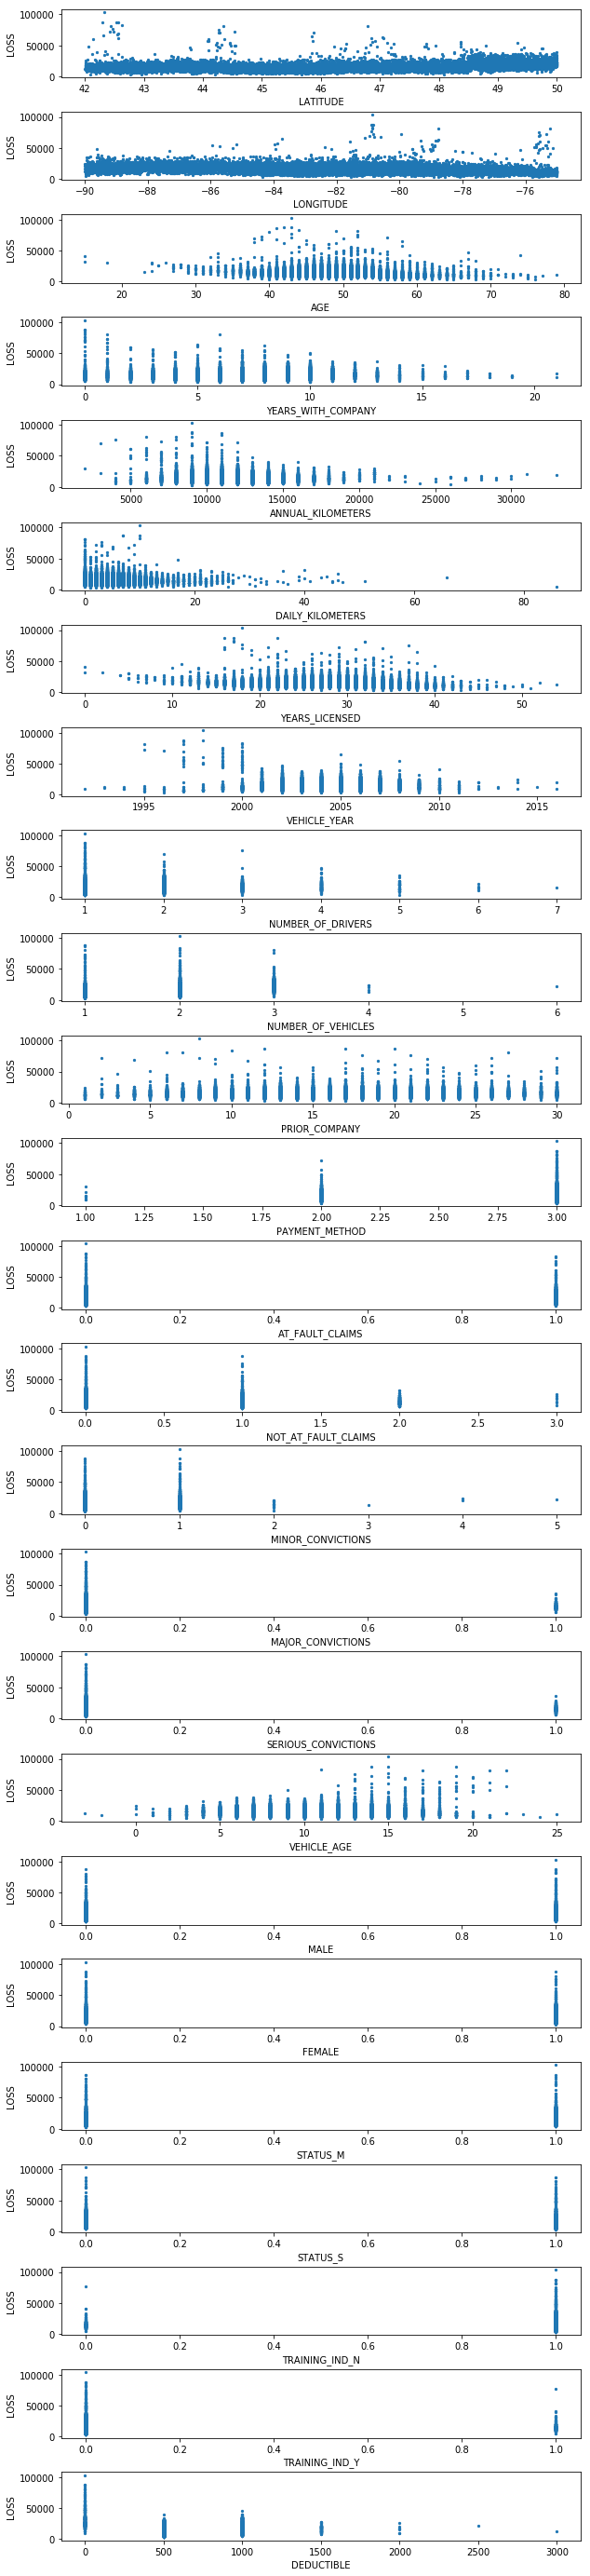

In [7]:
colnum=len(ilc.columns) - 1
fig,ax=plt.subplots(colnum,1,figsize=(10,50))
ax[0].set_ylabel("LOSS")
p_vals={}
plt.subplots_adjust(hspace = 0.5)
for ind,col in enumerate([i for i in ilc.columns if i not in ["LOSS"]]):    
    ax[ind].scatter(ilc[col],ilc.LOSS,s=5)
    ax[ind].set_xlabel(col)
    ax[ind].set_ylabel("LOSS")    
plt.show()